# AIM:
Convert a German sentence to its English using a Neural Machine Translation system

1. Data source: http://www.manythings.org/anki/

In [ ]:
https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
https://tommytracey.github.io/AIND-Capstone/machine_translation.html

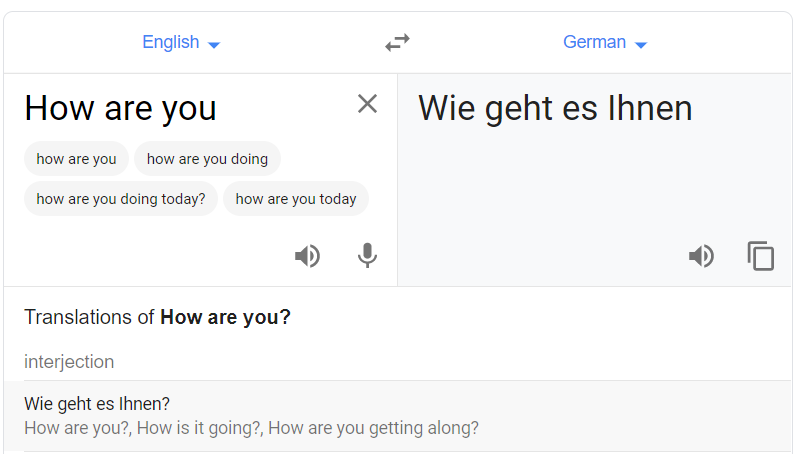

In [1]:
from IPython.display import Image
Image("ex.png")

# Seq --> Seq Modeling

Sequence-to-Sequence models are used such as 
1. text summarization, 
2. speech recognition, 
3. DNA sequence modeling 

Our aim is to translate given sentences from one language to another language.

seq2seq model has 2 major components –

1. encoder
2. decoder

Both these parts are essentially two different recurrent neural network (RNN) models combined into one giant network

1. Speech Recognition
2. Name Entity/Subject Extraction to identify the main subject from a body of text
3. Relation Classification to tag relationships between various entities tagged in the above step
4. Chatbot skills to have conversational ability and engage with customers
5. Text Summarization to generate a concise summary of a large amount of text
6. Question Answering systems

In [10]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

data is a text file (.txt) of English-German sentence pairs. First, we will read the file

In [11]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [12]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [13]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [14]:
deu_eng = deu_eng[:50000,:]

In [15]:
deu_eng

array([['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run!', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['I wholeheartedly agree.', 'Ich stimme rückhaltlos zu.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1488273 (Spamster) & #1693172 (al_ex_an_der)'],
       ['I will always love you.', 'Ich werde dich immer lieben.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #853146 (piksea) & #395302 (xtofu80)'],
       ['I will be back by nine.', 'Um neun bin ich wieder zurück.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #72281 (CK) & #345033 (lilygilder)']],
      dtype='<U537')

In [17]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run', 'Lauf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['I wholeheartedly agree', 'Ich stimme rückhaltlos zu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1488273 (Spamster) & #1693172 (al_ex_an_der)'],
       ['I will always love you', 'Ich werde dich immer lieben',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #853146 (piksea) & #395302 (xtofu80)'],
       ['I will be back by nine', 'Um neun bin ich wieder zurück',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #72281 (CK) & #345033 (lilygilder)']],
      dtype='<U537')

In [18]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['run', 'lauf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['i wholeheartedly agree', 'ich stimme rückhaltlos zu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1488273 (Spamster) & #1693172 (al_ex_an_der)'],
       ['i will always love you', 'ich werde dich immer lieben',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #853146 (piksea) & #395302 (xtofu80)'],
       ['i will be back by nine', 'um neun bin ich wieder zurück',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #72281 (CK) & #345033 (lilygilder)']],
      dtype='<U537')

# Text to Sequence Conversion

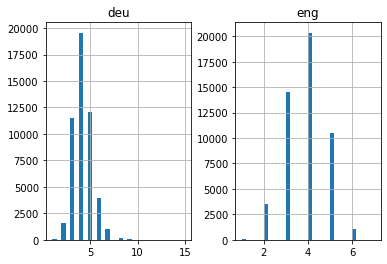

In [19]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [20]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [21]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6361


In [22]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10597


In [23]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

# Model Building

In [24]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [25]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [26]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [27]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [28]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [30]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 180s 6ms/step - loss: 3.5258 - val_loss: 2.9260

Epoch 00001: val_loss improved from inf to 2.92596, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 178s 6ms/step - loss: 2.8709 - val_loss: 2.8359

Epoch 00002: val_loss improved from 2.92596 to 2.83590, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 183s 6ms/step - loss: 2.7013 - val_loss: 2.6687

Epoch 00003: val_loss improved from 2.83590 to 2.66870, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 181s 6ms/step - loss: 2.5176 - val_loss: 2.5195

Epoch 00004: val_loss improved from 2.66870 to 2.51952, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [=============

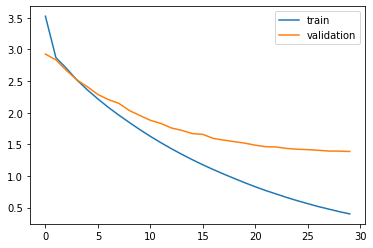

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [34]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [35]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [36]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [37]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
1959,were exhausted,were of
7790,its getting late,it be late
2409,ill watch tom,ill be tom
4279,may i go,may i go
7020,tom kept smiling,tom kept smiled
6890,youre vague,you look scare
3317,tom is a bad boy,tom is a boy
3574,thats your funeral,its is our
1585,i continued reading,i went on reading
4490,i hope you approve,i hope youd leave
